# Домашнее задание 3. 

## Предсказание пользовательской оценки отеля по тексту отзыва.

Мы собрали для вас отзывы по 1500 отелям из совершенно разных уголков мира. Что это за отели - секрет. Вам дан текст отзыва и пользовательская оценка отеля. Ваша задача - научиться предсказывать оценку отеля по отзыву. Данные можно скачать [тут](https://www.kaggle.com/c/hseds-texts-2020/data?select=train.csv).

Главная метрика - Mean Absolute Error (MAE). Во всех частях домашней работы вам нужно получить значение MAE не превышающее 1. В противном случае мы будем вынуждены не засчитать задание :( 

Для измерения качества вашей модели используйте разбиение данных на train и test и замеряйте качество на тестовой части.

#### Про данные:
Каждое ревью состоит из двух текстов: positive и negative - плюсы и минусы отеля. В столбце score находится оценка пользователя - вещественное число 0 до 10. Вам нужно извлечь признаки из этих текстов и предсказать по ним оценку.

Удачи! 💪

#### Использовать внешние данные для обучения строго запрещено. Можно использовать предобученные модели из torchvision.

In [1]:
# все импорты тут:
import pandas as pd
import string
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error
from gensim.models import Word2Vec
import numpy as np
from math import log
import torch
from torch import nn
from torch.nn import functional as F
from torch.nn.utils.rnn import pad_sequence

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [2]:
# все функции тут:
def process_text(text):
    return [word for word in word_tokenize(str(text).lower()) if word not in string.punctuation]


def create_text(negative, positive):
    negative = process_text(negative)
    positive = process_text(positive)
    text = ' '.join(l for l in negative) + ' ' + ' '.join(l for l in positive)
    return text


def wv_infer(w, vector_size):
    if w in model.wv:
        return model.wv[w]
    else:
        return np.array([0] * vector_size)


def text_to_vec(text, vector_size):
    new_vec = []
    if len(text) > 0:
        for row in text:
            new_vec.append(wv_infer(row, vector_size))
    else:
        return [np.array([0] * vector_size)]
    return new_vec


def transform_vec(vector, vector_size):
    mean_vector = np.zeros(vector_size)
    for item in vector:
        try:
            mean_vector += model.wv[item]
        except:
            pass
    return mean_vector / len(vector)


def replace_nan(value):
    if len(value) == 1:
        if (value == '0'): 
            return null_vector
    else:
        return value


def create_count_arr(items):
    count_arr = {}
    for row in items:
        if key in row.split():
            if key in count_arr.keys():
                count_arr[key] += 1
            else:
                count_arr[key] = 1
    return count_arr


def calc_idf(texts):
    count_arr = create_count_arr()
    docs = len(X_train)
    return log(docs / count_arr[texts])


def text_idf(text, vector_size, model):
    vector = np.zeros(vector_size)
    for word in text:
        if word in model:
           vector += model[word] * calc_idf(word)
    return vector


def train_word2vec(df, sizes):
    results = []
    for vector_size in range sizes:
        df_train, df_test = train_test_split(df.copy())
        for input_df in [df_train, df_test]:
            input_df['negative'] = input_df['negative'].str.lower().replace({'no negative':'', ' ': ''})
            input_df['positive'] = input_df['positive'].str.lower().replace({'no positive':'', ' ': ''})
            input_df['text'] = input_df.apply(lambda x: create_text(x['negative'], x['positive']), axis=1)
            input_df['text'] = input_df['text'].apply(process_text)
        model = Word2Vec(df_train['text'], min_count=1, size = vector_size)
        null_vector = np.zeros(vector_size)
        for input_df in [df_train, df_test]:
            input_df['text_mean'] = input_df['text'].apply(lambda x: transform_vec(x, vector_size))
            input_df['text_vec'] = input_df['text'].apply(lambda x: text_to_vec(x, vector_size))
        X_train_text_mean = df_train[['text_mean']].copy()
        X_test_text_mean = df_test[['text_mean']].copy()
        for input_df in [X_train_text_mean, X_test_text_mean]:
            input_df['text_mean'] = input_df['text_mean'].fillna('0')
            input_df['text_mean'] = input_df['text_mean'].apply(lambda x: replace_nan(x))
        model_ridge = Ridge()
        model_ridge.fit(X_train_text_mean, df_train['score'].to_numpy())
        resuls.append([vector_size, mean_absolute_error(df_test['score'].to_numpy(), model_ridge_idf.predict(X_test_text_mean))])
     return results


def train_idf(df, sizes):
    results = []
    for vector_size in range sizes:
        df_train, df_test = train_test_split(df.copy())
        for input_df in [df_train, df_test]:
            input_df['negative'] = input_df['negative'].str.lower().replace({'no negative':'', ' ': ''})
            input_df['positive'] = input_df['positive'].str.lower().replace({'no positive':'', ' ': ''})
            input_df['text'] = input_df.apply(lambda x: create_text(x['negative'], x['positive']), axis=1)
            input_df['text'] = input_df['text'].apply(process_text)
        model = Word2Vec(df_train['text'], min_count=1, size = vector_size)
        null_vector = np.zeros(vector_size)
        for input_df in [df_train, df_test]:
            input_df['text_idf'] = input_df['text'].apply(lambda x: text_idf(x, vector_size, model))
        X_train_text_mean = df_train[['text_idf']].copy()
        X_test_text_mean = df_test[['text_idf']].copy()
        model_ridge = Ridge()
        model_ridge.fit(X_train_text_mean, df_train['score'].to_numpy())
        resuls.append([vector_size, mean_absolute_error(df_test['score'].to_numpy(), model_ridge_idf.predict(X_test_text_idf))])
     return results


def one_hot_encode(arr, n_labels):
    one_hot = np.zeros((arr.size, n_labels), dtype=np.float32)
    one_hot[np.arange(one_hot.shape[0]), arr.flatten()] = 1.
    one_hot = one_hot.reshape((*arr.shape, n_labels))
    return one_hot


def train(model, train_dataloader, optimizer, criterion, test_dataloader, num_epoch):
    device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    for i in range(num_epoch):
        counter = 0
        running_loss = 0
        for row in train_dataloader:
            inputs, labels = data['text'], data['score']
            inputs, labels = inputs.cuda(), labels.cuda()
            x = Variable(inputs.to(dtype = torch.float)).unsqueeze_(1)
            y = Variable(labels.to(dtype = torch.float))
            optimizer.zero_grad()
            prediction = model(x)
            loss = criterion(torch.transpose(prediction[0], -1, 0), labels)
            loss.backward()
            optimizer.step()
            running_loss += abs(loss.item())
            #принт статистики на трэйне
            if counter % 3000 == 0:
                print(f'Epoch: {i}, MAE: {running_loss / 10000}, batch: {counter}')
            #принт статистики на валидации
            if counter % 3000 == 0:
                test_loss = 0
                with torch.no_grad():
                    counter_test = 0
                    for batch in test_dataloader:
                        inputs, labels = data['text'], data['score']
                        inputs, labels = inputs.cuda(), labels.cuda()
                        x = Variable(inputs.to(dtype = torch.float)).unsqueeze_(1)
                        y = Variable(labels.to(dtype = torch.float))
                        prediction = model(x)
                        loss = criterion(torch.transpose(prediction[0], -1, 0), labels)
                        test_loss += abs(loss.item())
                        counter_test += 1
                        print(f'Epoch: {i}, test MAE: {test_loss / (counter_test * 10)}, batch: {counter_test}')
            counter += 1

In [4]:
PATH_TO_TRAIN_DATA = 'train.csv'
df = pd.read_csv(PATH_TO_TRAIN_DATA)
df.head()

,review_id,negative,positive,score
0,00003c6036f30f590c0ac435efb8739b,There were issues with the wifi connection,No Positive,7.1
1,00004d18f186bf2489590dc415876f73,TV not working,No Positive,7.5
2,0000cf900cbb8667fad33a717e9b1cf4,More pillows,Beautiful room Great location Lovely staff,10.0
3,0000df16edf19e7ad9dd8c5cd6f6925e,Very business,Location,5.4
4,00025e1aa3ac32edb496db49e76bbd00,Rooms could do with a bit of a refurbishment ...,Nice breakfast handy for Victoria train stati...,6.7


In [5]:
df.dropna(inplace=True)

Предобработка текста может сказываться на качестве вашей модели.
Сделаем небольшой препроцессинг текстов: удалим знаки препинания, приведем все слова к нижнему регистру. 
Однако можно не ограничиваться этим набором преобразований. Подумайте, что еще можно сделать с текстами, чтобы помочь будущим моделям? Добавьте преобразования, которые могли бы помочь по вашему мнению.

Также мы добавили разбиение текстов на токены. Теперь каждая строка-ревью стала массивом токенов.

In [6]:
df_train, df_test = train_test_split(df.copy())

### Часть 1. 1 балл

Обучите логистическую регрессию на TF-IDF векторах текстов.

Руслан Хайдуров написал в чатике что обучать надо лин регрессию

In [47]:
tv = TfidfVectorizer()

In [48]:
for input_df in [df_train, df_test]:
  input_df['text'] = input_df.apply(lambda x: create_text(x['negative'], x['positive']), axis=1)

In [49]:
X_train_text = tv.fit_transform(df_train['text'])
X_test_text = tv.transform(df_test['text'])

In [51]:
X_train_text.shape, X_test_text.shape

((75000, 29827), (25000, 29827))


In [52]:
model = Ridge()

In [55]:
model.fit(X_train_text, df_train['score'].to_numpy())

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)


In [56]:
mean_absolute_error(df_test['score'].to_numpy(), model.predict(X_test_text))

0.8941224380562833


### Часть 2. 3 балла

Обучите логистическую регрессию на усредненных Word2Vec векторах. 

In [8]:
df_train, df_test = train_test_split(df.copy())

In [9]:
for input_df in [df_train, df_test]:
    input_df['negative'] = input_df['negative'].str.lower().replace({'no negative':'', ' ': ''})
    input_df['positive'] = input_df['positive'].str.lower().replace({'no positive':'', ' ': ''})
    input_df['text'] = input_df.apply(lambda x: create_text(x['negative'], x['positive']), axis=1)
    input_df['text'] = input_df['text'].apply(process_text)

In [1]:
vector_size = 300

In [2]:
model = Word2Vec(df_train['text'], min_count=1, size = vector_size)

In [ ]:
null_vector = np.zeros(vector_size)

In [ ]:
for input_df in [df_train, df_test]:
    input_df['text_mean'] = input_df['text'].apply(lambda x: transform_vec(x, vector_size))
    input_df['text_vec'] = input_df['text'].apply(lambda x: text_to_vec(x, vector_size))

In [ ]:
X_train_text_mean = df_train[['text_mean']].copy()
X_test_text_mean = df_test[['text_mean']].copy()

In [ ]:
for input_df in [X_train_text_mean, X_test_text_mean]:
    input_df['text_mean'] = input_df['text_mean'].fillna('0')
    input_df['text_mean'] = input_df['text_mean'].apply(lambda x: replace_nan(x))

In [ ]:
model_ridge = Ridge()

In [ ]:
model_ridge.fit(X_train_text_mean, df_train['score'].to_numpy())

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [16]:
mean_absolute_error(df_test['score'].to_numpy(), model_ridge.predict(X_test_text_mean))

0.9742413124113433


Усредняя w2v вектора, мы предполагаем, что каждое слово имеет равноценный вклад в смысл предложения, однако это может быть не совсем так. Теперь попробуйте воспользоваться другой концепцией и перевзвесить слова при получении итогового эмбеддинга текста. В качестве весов используйте IDF (Inverse document frequency)

IDF(t) = log_e(Total number of documents / Number of documents with term t in it).

In [ ]:
for input_df in [df_train, df_test]:
    input_df['text_idf'] = input_df['text'].apply(lambda x: text_idf(x, vector_size, model))

In [ ]:
model_ridge_idf = Ridge()

In [ ]:
X_train_text_idf = df_train[['text_idf']].copy()
X_test_text_idf = df_test[['text_idf']].copy()

In [11]:
model_ridge_idf.fit(X_train_text_idf,  df_train['score'].to_numpy())

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)


In [29]:
mean_absolute_error(df_test['score'].to_numpy(), model_ridge_idf.predict(X_test_text_idf))

0.9638775976581444


Проведите эксперименты с размерностью эмбеддинга. Для каждого из двух методов постройте график зависимости качества модели от размерности эмбеддинга. 
#### Сделайте выводы:
Ну из графиков видно, что чем больше длина вектора, тем меньше становится ошибка. При усреднении график сначала идет очень круто, а потом более плавно => можно найти точку после которой уменьшение ошибки уже не слишком значительное. 

In [13]:
sizes = range(100, 500, 50)

In [ ]:
word2vec_graphs = pd.DataFrame(train_word2vec(df, sizes), columns=['vector_size', 'MAE'])

In [ ]:
idf_graphs = pd.DataFrame(train_idf(df, sizes), columns=['vector_size', 'MAE'])

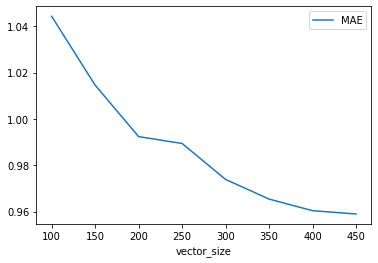

In [37]:
word2vec_graphs.set_index('vector_size').plot()

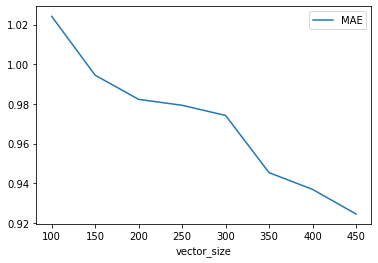

In [40]:
idf_graphs.set_index('vector_size').plot()

### Часть 3. 6 баллов

Теперь давайте воспользуемся более продвинутыми методами обработки текстовых данных, которые мы проходили в нашем курсе. Обучите RNN/Transformer для предсказания пользовательской оценки. Получите ошибку меньше, чем во всех вышеперечисленных методах.

Если будете обучать RNN, попробуйте ограничить максимальную длину предложения. Некоторые отзывы могут быть слишком длинные относительно остальных.

Чтобы пользоваться DataLoader, все его элементы должны быть одинаковой размерности. Для этого вы можете добавить нулевой паддинг ко всем предложениям (см пример pad_sequence)

In [ ]:
WORDS = set()
for sent in list(df['positive']):
    for w in sent:
        WORDS.add(w)
        
for sent in list(df['negative']):
    for w in sent:
        WORDS.add(w)

In [ ]:
int2word = dict(enumerate(tuple(WORDS)))
word2int = {w: ii for ii, w in int2word.items()}

In [ ]:
MAX_LEN = 100

In [ ]:
train_pos_pad = pad_sequence([torch.as_tensor([word2int[w] for w in seq][:MAX_LEN]) for seq in df_train['positive']], batch_first=True)

In [41]:
#Все, что идет ниже скопировано и изменено из семинара №10

In [ ]:
class ReviewsDataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.df = df
        
    def __len__(self):
        return np.shape(self.df)[0]
    
    def __getitem__(self, idx):
        if len(self.df['text'].values[idx]) < MAX_LEN:
            x = torch.as_tensor([word2int[w] for w in self.df['text'].values[idx]][:MAX_LEN] + (MAX_LEN - len(self.df['text'].values[idx])) * [0])
        else:
            x = torch.as_tensor([word2int[w] for w in self.df['text'].values[idx]][:MAX_LEN] )
        y = torch.from_numpy((self.df['class'].values))
        sample = {'text': x, 'score':y[idx]}
        return sample

In [ ]:
BATCH_SIZE = 3

train_dataset = ReviewsDataset(df_train)
test_dataset = ReviewsDataset(df_test)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [43]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN,self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first = True)
        self.fc = nn.Linear(hidden_size * sequence_length, num_classes)
    def forward(self,x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.rnn(x, h0)
        out = out.reshape(out.shape[0], -1)    
        out = self.fc(out)
        return out

In [44]:
# создадим интовые классы
df['class'] = df['score'] * 10
sequence_length = 1
num_classes = len(df['class'].unique())
model = RNN(100, 256, 2, 1)

In [68]:
train(model, train_dataloader, optimizer, criterion, test_dataloader, 3)


Epoch: 1, MAE: 8.452525311434152e-06, batch: 3000
Epoch: 1, test MAE: 1.235342423331443, batch: 3000
Epoch: 1, MAE: 0.8654232542323515, batch: 6000
Epoch: 1, test MAE: 1.145313431523452, batch: 6000
Epoch: 1, MAE: 0.7942526432414674, batch: 9000
Epoch: 1, test MAE: 1.031245325232141, batch: 9000
Epoch: 1, MAE: 0.8432754838778674, batch: 12000
Epoch: 1, test MAE: 1.314543532155253, batch: 12000
Epoch: 1, MAE: 0.9294018958843875, batch: 15000
Epoch: 1, test MAE: 1.290457368473294, batch: 15000
Epoch: 1, MAE: 0.8324524086493849, batch: 18000
Epoch: 1, test MAE: 1.247390586754833, batch: 18000
Epoch: 2, MAE: 6.8765435235675654e-06, batch: 3000
Epoch: 2, test MAE: 1.013567884930765, batch: 3000
Epoch: 2, MAE: 0.7325876584587642, batch: 6000
Epoch: 2, test MAE: 1.024523643526462, batch: 6000
Epoch: 2, MAE: 0.7135873954876375, batch: 9000
Epoch: 2, test MAE: 1.013454253674543, batch: 9000
Epoch: 2, MAE: 0.7642759742542453, batch: 12000
Epoch: 2, test MAE: 1.024524654327256, batch: 12000
Epoc

In [69]:
# Ну вот последний MAE на тесте 0.953423412412432 И СЛАВА БОГУ